In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit 
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Bayesian Linear Regression avec une prior de Laplace

Dans ce notebook, nous appliquons la Stochastic Gradient Langevin Dynamics afin d'effectuer une Bayesian Linear Regression avec une prior de Laplace de scale $b=1$. Pour le moment, nous fixons la variance de la likelihood gaussienne à $\sigma^2=1$. Nous comparons également la Stochastic Gradient Langevin Dynamics à d'autres méthodes d'échantillonnage afin de tester son efficacité et notamment sa rapidité.

On rappelle le modèle:

- $p(\beta) \sim \mathcal{L}(0, 1)$ i.e $p(\beta) \propto \exp(-\|\beta\|_1)$,

- $ \forall i \in \{1, ..., N\}, y_i \sim \mathcal{N}(x_i^{\top}\beta, \sigma^2)$, i.i.d.

On a alors $\log p(\beta | X, y) \propto_+  - \sum_{i=1}^N (x_i^{\top}\beta - y_i)^2 - \|\beta \|_1 = - \|X\, \beta - y\|_2^2 - \|\beta \|_1$

En utilisant le fait qu'un sous-gradient de la log-prior est $\partial_{\beta} \log p(\beta) = - \mathrm{sign}(\beta)$ et en notant $X$ la matrice des données, i.e 
$X = \begin{pmatrix}
x_1\\
...\\
x_n:
\end{pmatrix} \in \mathbb{R}^{n \times d}$ et $y$ le vecteur des labels, on peut écrire un sous gradient de la log-posterior:
$$ 
\partial_{\beta} \log p(\beta | X, y) = - X^{\top}X \, \beta + X^{\top}y - \mathrm{sign}(\beta)
$$

## 1. Stochastic Gradient Langevin Dynamics

Nous référons le lecteur au notebook ``bayes_logreg_laplace.ipynb`` pour une description plus complète de la méthode Stochastic Gradient Langevin, notamment de la dynamique en deux phases: optimisation et échantillonnage.  
Nous rappelons ici une itération de l'algorithme, dans le cas particulier de la Bayesian Linear Regression avec une prior de laplace de scale $b=1$. 

### 1.1 Une itération

En exploitant les calculs précédents, l'itération $t$ de la **SGLD** s'écrit:

- Selectionner un batch $B_t = \{x_{i_1}, ..., x_{i_n}\}$, former la matrice des données correspondante $X_B = \begin{pmatrix}
x_{i_1}\\
...\\
x_{i_n}:
\end{pmatrix} \in \mathbb{R}^{|B| \times d}$  et $y_B$ le vecteur de label correspondant
- 
calculer la step-size $\epsilon_t = a \cdot (b+t)^{-\gamma}$

- Échantilloner $\eta_t \sim \mathcal{N}(0,\epsilon_t \cdot I)$

- Mettre à jour $\beta_{t+1} \leftarrow \beta_t + \frac{1}{2} \epsilon_t \cdot \left[ \frac{N}{n} \left( - X_B^{\top}X_B \, \beta + X_B^{\top}y_B \right) - \mathrm{sign}(\beta)\right] + \eta_t$

### 1.2 Implémentation

In [2]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)

def post_laplace(beta, X, y, sigma2=1):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels
      sigma2: float, noise of the Gaussian likelihood
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    mean = X @ beta
    cov = sigma2 * np.eye(len(X))
    return multivariate_normal(mean=mean, cov=cov).pdf(y) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y, sigma2=1):
    """
    Evaluate the (unormalized) log-posterior pdf over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
      sigma2: float, noise of the Gaussian likelihood
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return - (1/2) * np.linalg.norm(X @ beta - y, ord=2)**2 - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False, sigma2=1):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples 
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
      sigma2: float, noise of the Gaussian likelihood
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient 
    batch_grad = (n_samples / len(batch_X)) * (- batch_X.T @ batch_X @ beta + batch_X.T @ batch_y) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad
    
    # get empirical covariance of the score if required
    else:
        # get score 
        res = -  ((batch_X @ beta) - batch_y)[:, None] * batch_X
        res2 = res - (1/n_samples) * np.sign(beta)

        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.mean(0)).T @ (res2 - res2.mean(0))
        return batch_grad, cov_score 

def SGLD_linreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, sigma2=1, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SGLD for Bayesian Linear Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      sigma2: float, noise of the Gaussian likelihood
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)
    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
    
    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size 
        step_size = get_step_size(a, b, gamma, t=ii)
        
        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))
        
        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta 
        betas[ii+1] = beta
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
            
        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))
            
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW: 
        return betas, trackA, trackW
    if bool_trackA & bool_trackL: 
        return betas, trackA, trackL
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA 
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas
    
def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get an approimation of the mean of predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=1
    if np.all(weights)==None:
        return (X_new @ samples[burn_in+1:].T).mean(1) 
    else:
        return (weights[None, burn_in:] * X_new @ samples[burn_in+1:].T).sum(1) / weights[burn_in:].sum()
    
def get_mse_iter(X, y, samples, burn_in=None):
    """
    Get the mean squared error (training or testing) given by the sample at each iteration.
    Arguments:
      X: np.array, training or testing examples
      y: np.array,  training or testing labels
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
    Return:
      np.array, accuracy (training or testing) at each iteration
    """
    if burn_in==None:
        burn_in=1
    return (X @ samples[burn_in:].T - y[:, None]).var(0)

### 1.3 Application sur des données synthétiques 

Dans cette section, on teste notre implémentation de la SGLD sur un dataset dans $\mathbb{R}$. Ainsi, nous pouvons tester la validité de notre méthode.

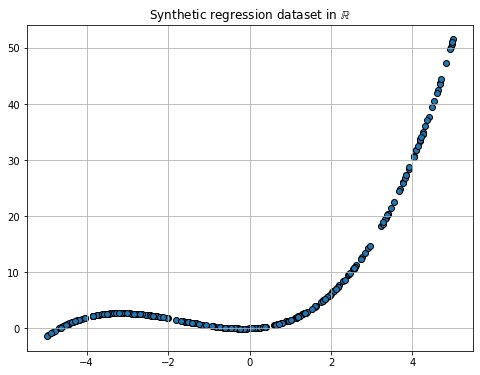

In [3]:
# load linearly separable dataset
x = np.linspace(-5, 5, 1000)[np.random.choice(1000, size=250)]
y = .2 * x**3 + x**2 + .3 * x

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k')
plt.title("Synthetic regression dataset in $\mathbb{R}$")
plt.grid()
plt.show()

In [4]:
# polynomial transformation of the features
poly = PolynomialFeatures(3, include_bias=False)
phi_X = poly.fit_transform(x[:, None])

# standardize data 
scaler = StandardScaler().fit(phi_X)
phi_X = scaler.transform(phi_X)

# add bias
phi_X = np.concatenate((np.ones(len(phi_X))[:, None], phi_X), axis=1)
                       
print(f"Number of points: {phi_X.shape[0]}.")
print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

Number of points: 250.
Number of dimension of the new covariates: 4.


In [27]:
a = .005
b = 50
gamma = .7
batch_size = 5
beta_0 = np.zeros(phi_X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackA=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5831.68it/s]


Done in 0.87 s.

Computing just the log-posterior at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5193.32it/s]


Done in 0.97 s.

Computing just the alphas at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3941.10it/s]


Done in 1.28 s.

Computing both the log-posterior and the alphas at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3255.01it/s]


Done in 1.54 s.


In [28]:
a = .01
b = 50
gamma = .6
batch_size = 20
beta_0 = betas[-1] # re-inject last sample in the next run
n_iter = 5000

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackW, trackA, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size,bool_trackA=True, bool_trackL=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3230.03it/s]


Done in 1.55 s.


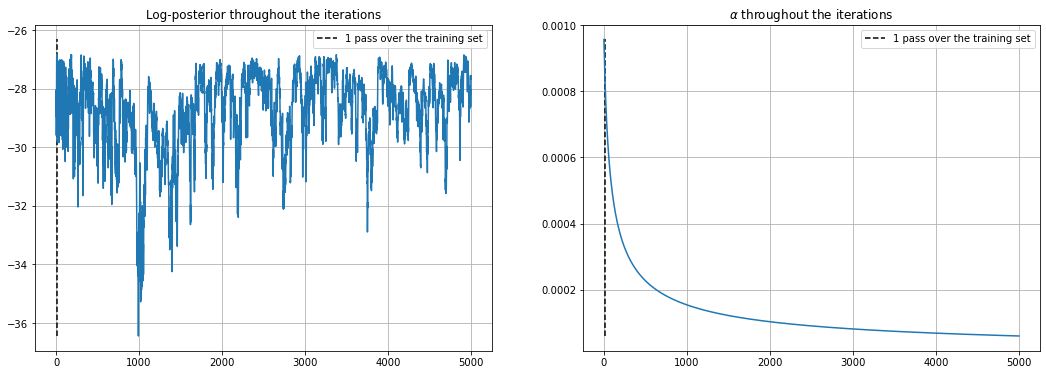

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = phi_X.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max(), ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()


plt.show()

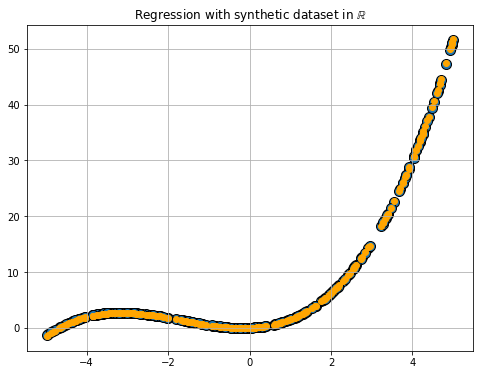

In [9]:
# visualize reusults 
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k', s=100)
plt.scatter(x, phi_X @ betas[-100:].mean(0), color='orange', lw=1)
plt.title("Regression with synthetic dataset in $\mathbb{R}$")
plt.grid()
plt.show()

### 1.4 Application sur des données réelles

In [35]:
# load the dataset
data = pd.read_csv("train.csv")
print(f"Number of instances: {data.shape[0]}")
print(f"Number of attributes: {data.shape[1]-1}")
data.head()

Number of instances: 21263
Number of attributes: 81


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [36]:
# pre-process data
X_ = data[data.columns[:-1]].values

# pre-process labels
y_ = data[data.columns[-1]].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.25, random_state=42)

print(f"Number of training examples: {len(X_train)}.")
print(f"Number of testing examples: {len(X_test)}.")

Number of training examples: 15947.
Number of testing examples: 5316.


In [37]:
# fit scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

In [38]:
a = .0001
b = 100
gamma = .6
batch_size = 20
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackA=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1166.71it/s]


Done in 4.29 s.

Computing just the log-posterior at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 671.49it/s]


Done in 7.45 s.

Computing just the alphas at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 333.45it/s]


Done in 15.0 s.

Computing both the log-posterior and the alphas at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 260.00it/s]


Done in 19.24 s.


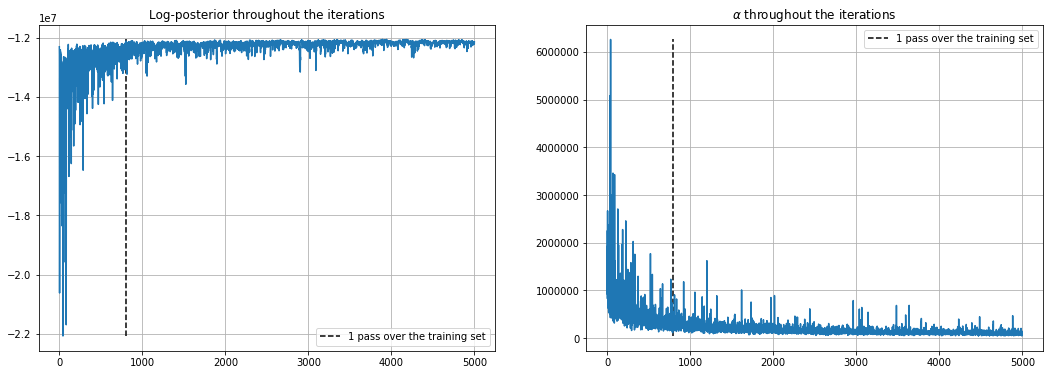

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max(), ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()


plt.show()

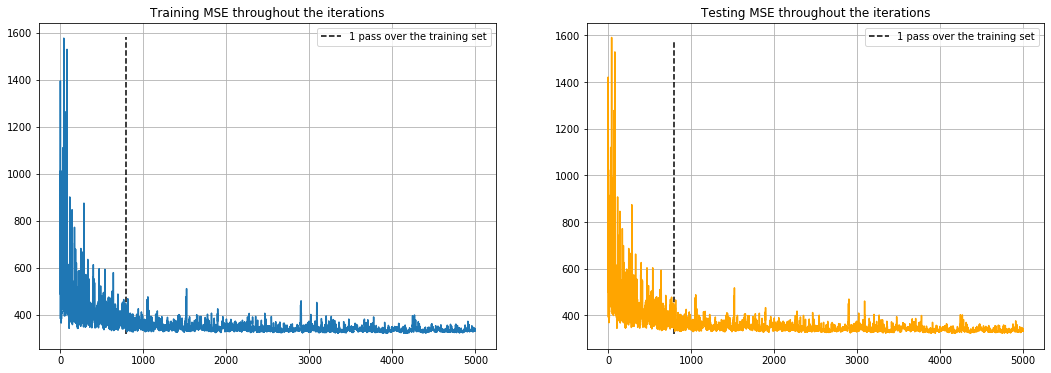

In [40]:
# get the training accuracy at each iteration 
mses_train = get_mse_iter(X_train, y_train, samples=betas)

# get the testing accuracy at each iteration 
mses_test = get_mse_iter(X_test, y_test, samples=betas)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=mses_train.min()-3, ymax=mses_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(mses_train)
ax[0].set_title("Training MSE throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=mses_test.min()-3, ymax=mses_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(mses_test, c='orange')
ax[1].set_title("Testing MSE throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

## 2. Comparaison avec SAGA-LD

SAGA-LD, une variante de l'algorithme SAGA, vise à réduire la variance de SGLD due à l'information manquante. En effet, SGLD ne considère le gradient de la vraisemblance que sur un batch de taille $n\ll N$ et donc qu'une petite partie de l'information. 

SAGA-LD estime les gradients sur le reste du jeu de données. A chaque point $i$ correpond un gradient approximé $g_{\alpha i}$, qui est utilisé en tant que gradient de la log-vraisemblance pour tous les points **n'appartenant pas** au batch. Ainsi, il réduit la variance dans la stochasticité de la descente de gradient.

### 2.1 Description de l'algorithme

L'algorithme garde en mémoire un vecteur $\alpha_t$ mis à jour selon :

$$
\alpha_{t+1}^i \leftarrow \theta_t \text{ si }i\text{ appartient au batch, }\alpha_t^i\text{ sinon.}
$$

et le gradient approximé $g_\alpha$ devient :

$$
g_\alpha \leftarrow g_\alpha +  \sum \limits_{i\in batch} (\nabla p(x_i|\alpha_{t+1}^i) - \nabla p(x_i|\alpha_t^i))
$$

Enfin, la mise à jour de $\theta$ devient, en considérant un pas $\varepsilon_t$ :

$$
\theta_{t+1} \leftarrow \theta_t + \frac{\varepsilon_t}{2}(\nabla \log p(\theta_t) + \frac{N}{n} \sum \limits_{i\in batch} (\nabla \log p(x_i | \theta_t) - \nabla \log p(x_i | \alpha_t^i) ) + g_\alpha) + \eta_t
$$

avec $N$ le nombre d'échantillons dans notre ensemble de données, $n$ la taille de notre batch, et $\eta_t \sim \mathcal{N}(0, \varepsilon_t I)$.

Cet algorithme est plus lourd en mémoire que SGLD, puisqu'il stocke une estimation des gradients pour chacun des paramètres. Il existe une variante plus légère cependant, que nous n'utilisons pas ici.

### 2.2 Implémentation

In [4]:
def gradient_loglik_with_alphas(alphas, batch_X, batch_y, n_samples, sigma2=1):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t an array of alphas for a given batch. Used in SAGA-LD.
    Arguments:
      alphas: np.array of size batch_size x parameters
      batch_X: np.array, batch of training examples 
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      sigma2: float, noise of the Gaussian likelihood
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient
    batch_grad = np.zeros_like(alphas[0])
    for i in range(batch_X.shape[0]):
        batch_grad -= batch_X[i].T[:, None] @ batch_X[i][None, :] @ alphas[i]
    batch_grad = (n_samples / len(batch_X)) * (batch_grad + batch_X.T @ batch_y)

    return batch_grad


def SAGA_LD_linreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, sigma2=1, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SAGA_LD for Bayesian Linear Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      sigma2: float, noise of the Gaussian likelihood
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)
    
    alphas = np.array([beta_0 for _ in range(N)])
    g = gradient_loglik_with_alphas(alphas, X, y, n_samples=N)
    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
    
    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size 
        step_size = get_step_size(a, b, gamma, t=ii)
        
        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))
        
        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
            
        # compute gradient of log likelihood with alphas
        grad_alpha = gradient_loglik_with_alphas(alphas[idxs], batch_X, batch_y, n_samples=N)
        
        # update alpha
        alphas[idxs] = beta
        
        # compute gradient of log likelihood with new alphas
        new_grad_alpha = gradient_loglik_with_alphas(alphas[idxs], batch_X, batch_y, n_samples=N)
                                               
        beta = beta + (step_size / 2) * (grad - grad_alpha + g) + eta 
        betas[ii+1] = beta

        # update g
        g += (new_grad_alpha - grad_alpha) * batch_size / N
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
            
        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))
            
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW: 
        return betas, trackA, trackW
    if bool_trackA & bool_trackL: 
        return betas, trackA, trackL
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA 
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas

### 1.3 Application sur des données synthétiques 

Utilisons SAGA-LD sur le jeu de données synthétiques utilisé dans la première partie.

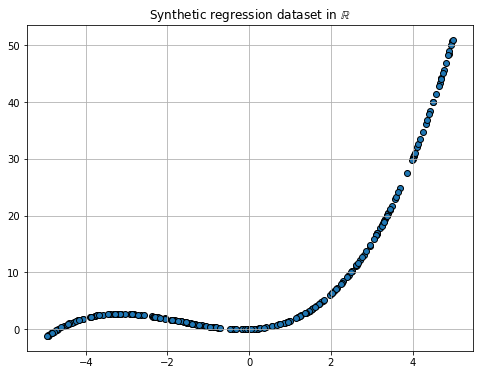

Number of points: 250.
Number of dimension of the new covariates: 4.


In [25]:
# load linearly separable dataset
x = np.linspace(-5, 5, 1000)[np.random.choice(1000, size=250)]
y = .2 * x**3 + x**2 + .3 * x

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k')
plt.title("Synthetic regression dataset in $\mathbb{R}$")
plt.grid()
plt.show()

# polynomial transformation of the features
poly = PolynomialFeatures(3, include_bias=False)
phi_X = poly.fit_transform(x[:, None])

# standardize data 
scaler = StandardScaler().fit(phi_X)
phi_X = scaler.transform(phi_X)

# add bias
phi_X = np.concatenate((np.ones(len(phi_X))[:, None], phi_X), axis=1)
                       
print(f"Number of points: {phi_X.shape[0]}.")
print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

In [26]:
a = .005
b = 50
gamma = .7
batch_size = 5
beta_0 = np.zeros(phi_X.shape[1])
n_iter = 5000

# without computing log-posterior at each step
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas_saga = SAGA_LD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas_saga, _ = SAGA_LD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas_saga, _ = SAGA_LD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackA=True)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas_saga, _, trackL_saga = SAGA_LD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3414.41it/s]


Done in 1.48 s.

Computing just the log-posterior at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2932.40it/s]


Done in 1.71 s.

Computing just the alphas at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2292.91it/s]


Done in 2.19 s.

Computing both the log-posterior and the alphas at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2068.42it/s]


Done in 2.43 s.


In [29]:
beta_0 = betas_saga[-1]

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackW_saga, trackA_saga, trackL_saga = SAGA_LD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size,bool_trackA=True, bool_trackL=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1860.35it/s]


Done in 2.69 s.


&nbsp;

**!! ATTENTION !!** Pour comparer SAGA-LD avec SGLD, nous utilisons les résultats de SGLD calculés précédemment. Il est conseillé de relancer l'algorithme SGLD pour le dataset corespondant.

&nbsp;

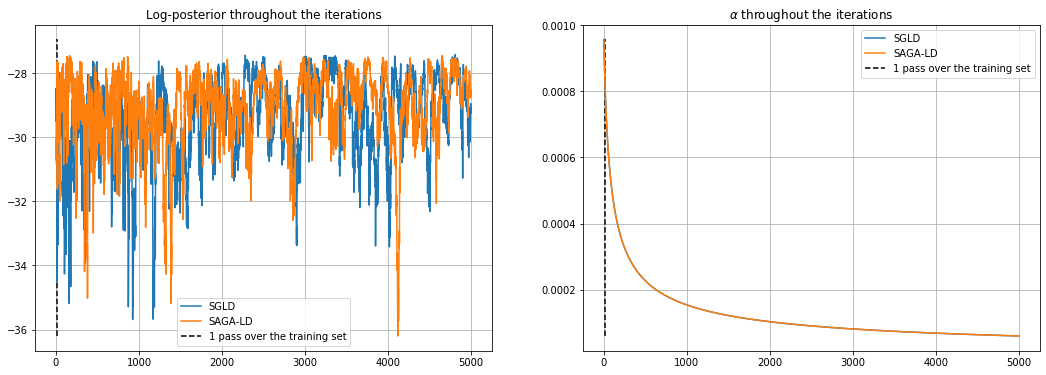

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = phi_X.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL_saga.min(), ymax=trackL_saga.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL, label="SGLD")
ax[0].plot(trackL_saga, label="SAGA-LD")
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max(), ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA, label="SGLD")
ax[1].plot(trackA_saga, label="SAGA-LD")
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()


plt.show()

Sur ce jeu de données, la variance du gradient stochastique est relativement faible, et les résultats de SGLD et SAGA-LD sont donc **sensiblement similaires**. Comme l'on peut le voir sur la figure ci dessous, la régression linéaire parvient bien à apprendre le jeu de données synthétiques. 

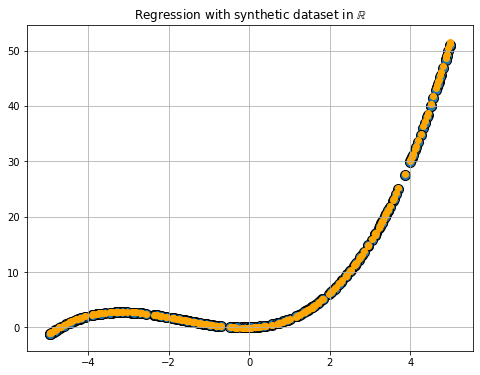

In [33]:
# visualize reusults 
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k', s=100)
plt.scatter(x, phi_X @ betas_saga[-100:].mean(0), color='orange', lw=1)
plt.title("Regression with synthetic dataset in $\mathbb{R}$")
plt.grid()
plt.show()

### 2.4 Données réelles

Utilisons maintenant la régression linéaire bayésienne entraînée avec l'algorithme SAGA-LD sur un jeu de données réelles. Sur ces données, le gradient stochastique calculé sur un batch (qui correspond à une toute petite partie des données) devrait avoir une variance importante, ce qui **ralentit** et **rend instable** la convergence de SGLD.

&nbsp;

**!! ATTENTION !!** Pour comparer SAGA-LD avec SGLD, nous utilisons les résultats de SGLD calculés précédemment. Il est conseillé de relancer l'algorithme SGLD pour le dataset corespondant.

&nbsp;

In [3]:
# load the dataset
data = pd.read_csv("train.csv")
print(f"Number of instances: {data.shape[0]}")
print(f"Number of attributes: {data.shape[1]-1}")

# pre-process data
X_ = data[data.columns[:-1]].values

# pre-process labels
y_ = data[data.columns[-1]].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.25, random_state=42)

print(f"Number of training examples: {len(X_train)}.")
print(f"Number of testing examples: {len(X_test)}.")

# fit scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

Number of instances: 21263
Number of attributes: 81
Number of training examples: 15947.
Number of testing examples: 5316.


In [41]:
a = .0001
b = 100
gamma = .6
batch_size = 20
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas_saga = SAGA_LD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas_saga, trackL_saga = SAGA_LD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas_saga, trackA_saga = SAGA_LD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackA=True)

# re-inject last sample in the next run
beta_0 = betas_saga[-1]

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas_saga, trackA_saga, trackL_saga = SAGA_LD_linreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 487.49it/s]


Done in 10.55 s.

Computing just the log-posterior at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 337.01it/s]


Done in 15.16 s.

Computing just the alphas at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 245.08it/s]


Done in 20.71 s.

Computing both the log-posterior and the alphas at each step:


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 207.11it/s]

Done in 24.55 s.


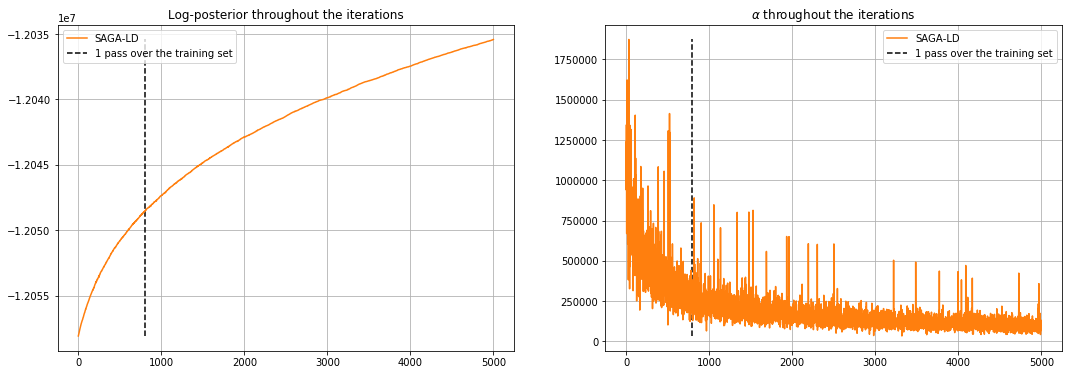

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL_saga.min(), ymax=trackL_saga.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
# ax[0].plot(trackL, label="SGLD")
ax[0].plot(trackL_saga, label="SAGA-LD", c="tab:orange")
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA_saga.min(), ymax=trackA_saga.max(), ls='--', color='k', label=f'{num_epoch} pass over the training set')
# ax[1].plot(trackA, label="SGLD")
ax[1].plot(trackA_saga, label="SAGA-LD", c="tab:orange")
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()


plt.show()

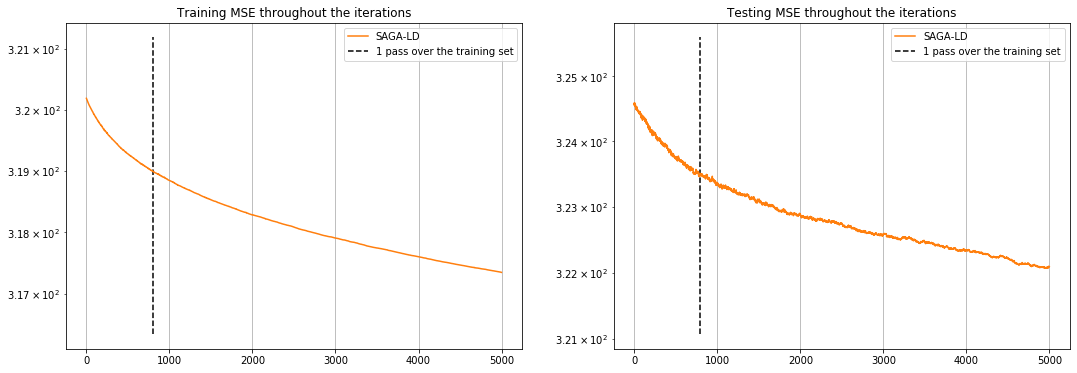

In [53]:
# get the training accuracy at each iteration 
mses_train_saga = get_mse_iter(X_train, y_train, samples=betas_saga)

# get the testing accuracy at each iteration 
mses_test_saga = get_mse_iter(X_test, y_test, samples=betas_saga)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=mses_train_saga.min()-1, ymax=mses_train_saga.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(mses_train_saga, label="SAGA-LD", c="tab:orange")
ax[0].set_title("Training MSE throughout the iterations")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=mses_test_saga.min()-1, ymax=mses_test_saga.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(mses_test_saga, label="SAGA-LD", c="tab:orange")
ax[1].set_title("Testing MSE throughout the iterations")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].grid()

plt.show()

L'erreur des moindres carrés de la régression linéaire obtenue par SAGA-LD diminue de manière **bien plus stable** que ne le faisait la régression linéaire obtenue avec SGLD. Comparons maintenat les deux méthodes entre elles.

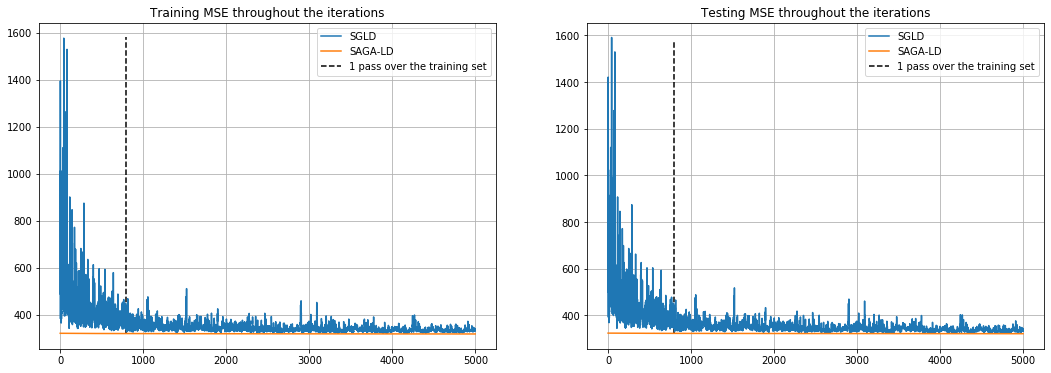

In [55]:
# get the training accuracy at each iteration 
mses_train = get_mse_iter(X_train, y_train, samples=betas)

# get the testing accuracy at each iteration 
mses_test = get_mse_iter(X_test, y_test, samples=betas)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=mses_train.min()-3, ymax=mses_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(mses_train, label="SGLD")
ax[0].plot(mses_train_saga, label="SAGA-LD")
ax[0].set_title("Training MSE throughout the iterations")
ax[0].legend()
# ax[0].set_yscale('log')
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=mses_test.min()-3, ymax=mses_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(mses_test, label="SGLD")
ax[1].plot(mses_test_saga, label="SAGA-LD")
ax[1].set_title("Testing MSE throughout the iterations")
ax[1].legend()
# ax[1].set_yscale('log')
ax[1].grid()

plt.show()

Sur ce jeu de données **réelles**, l'on peut voir que réduire la variance du gradient stochastique est particulièrement efficace, puisque SAGA-LD semble avoir convergé bien plus tôt vers une zone de faible erreur des moindres carrés. Même après plusieurs redémarrages de SGLD à une initialisation raisonnable, la performance de l'algorithme fluctue énormément.